We extract video frames from selected animations and extract
the line art images to form our training dataset. We calculate a
**768-dimensional feature vector of histograms of R, G, B channels
for each frame**. The difference between frames is determined by
calculating the **mean square error** of the feature vectors, which
is used for splitting the source animations into shots. When the
difference between the neighboring frames is **greater than 200**, it
is considered to belong to different shots. In order to improve the
quality of the data, we **remove shots in which the mean square
errors between all pairs of frames are less than 10** (as they are
too uniform), and **the shot with a length less than 8 frames**.
Then we **filter out video frames that are too dark or too faded
in color**. Finally we get a total of 
1096 video sequences from 6 animations, with a total of 29,834 images. 
Each video sequence
has 27 frames on average. 

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import shutil
import os
import pandas

Let's create the frames.

In [5]:

def VidToFrames (vidpath, folderName):
    vidcap = cv2.VideoCapture(vidpath)
    success,image = vidcap.read()
    print(success)
    count = 0
    length = int(vidcap.get(cv2.CAP_PROP_FPS))
    width  = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(length, width, height)
    while success:
        cv2.imwrite("{foldername}/{frameNum}.png".format(foldername= folderName, frameNum=str(count)), image)  
        success,image = vidcap.read()
        count += 1
    print(count, "frames in file")

for i in glob.glob("../mp4/*.mp4"):
    destination = i.split('.mp4')[0]
    os.mkdir(destination)
    VidToFrames(i, destination)   

True
29 640 360
24731 frames in file


Now that we have folders with frames from each video for each channelId, we can start the analysis. There is two parts to this: 
1. Color analysis
2. Motion analysis

### Part I  <br/>
***Color Analysis*** <br/>
Is there a correlation between color and subcount?

In [ ]:
from IPython.display import Image

def removeDimAndFadedImages(folderName):
    sortedFrameList = sorted(glob.glob(folderName+'/*.png'), key=os.path.getmtime)
    debugCount = 0
    for imagePath in sortedFrameList:
        brightness = getBrightnessOfImage(imagePath)
        if brightness < 9.4e7 or brightness > 4.5e8: # brightness < 6*10^7 or brightness > 7*10^8:
            print(imagePath, ": ", brightness)
            os.remove(imagePath)
        if debugCount % 100 == 0: 
            print (debugCount)
        debugCount +=1

        
def getBrightnessOfImage(imagePath):
    image = cv2.imread(imagePath)
    vectors = []
    for i, col in enumerate(['b', 'g', 'r']):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        sums = np.sum(np.fromiter((index*hist[index] for index in range(len(hist))), dtype=float))
        vectors.append(sums)
        plt.plot(hist, color = col)
        plt.xlim([0, 256])
    plt.show()
    totalSums = np.sum(vectors)
    return totalSums

An image histogram gives a graphical representation of the distribution of pixel intensities in a digital image.

In [1]:
def binAndPlot(some_list):
    sorted_list = sorted(some_list)
    sorted_counted = Counter(sorted_list)
    range_length = list(range(int(max(some_list)+1))) # Get the largest value to get the range.
    data_series = {}

    for i in range_length:
        data_series[i] = 0 # Initialize series so that we have a template and we just have to fill in the values.
    for key, value in sorted_counted.items():
        data_series[key] = value
    data_series = pd.Series(data_series)
    x_values = data_series.index
    plt.hist(some_list, bins=10, edgecolor="yellow", color="green")
    plt.show()

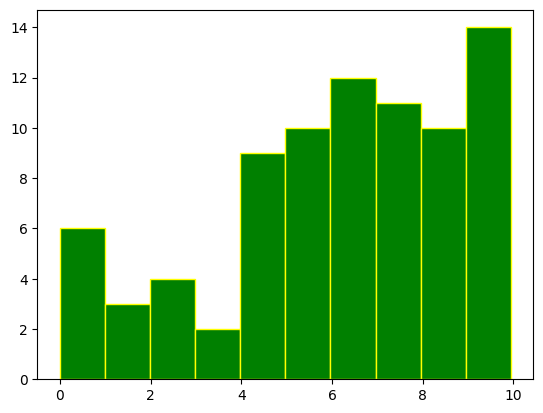

DIFF
min:  0.0  max:  9.942708 mean:  6.079476


In [6]:
def DIFF_images(A, B):
    return (np.abs(A - B)).mean()

def distributionOfMSEandDIFF(folderName):
    sortedFrameList = sorted(glob.glob(folderName+'/*.png'), key=os.path.getmtime)
    debugMsg = 0
    listOfDIFF2 =[]
    for i in range(len(sortedFrameList)-1):
        firstFrame = sortedFrameList[i]
        secondFrame = sortedFrameList[i+1]
        f1_v = getFeatureVectorOfImage(firstFrame)
        f2_v = getFeatureVectorOfImage(secondFrame)
        diff = DIFF_images(f1_v, f2_v)
        if diff <= 10:
            listOfDIFF2.append(diff)

    binAndPlot(listOfDIFF2)

    print("DIFF")
    print("min: ", np.amin(listOfDIFF2), " max: ", np.amax(listOfDIFF2), "mean: ", np.mean(listOfDIFF2))

# removeLowMSE('anime_dir3')
# distributionOfMSEandDIFF('CCS1') #40
# distributionOfMSEandDIFF('CCS2') #40
# distributionOfMSEandDIFF('LWA') #35
# distributionOfMSEandDIFF('NRT')#30
# distributionOfMSEandDIFF('AKR') #40
distributionOfMSEandDIFF('frames') #40
# distributionOfMSEandDIFF('FMA2') #40








In [5]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
HEIGHT  = 720
WIDTH = 1280
DIFF= 1
def getFeatureVectorOfImage (imagePath):
    image = cv2.imread(imagePath)
    vectors = []
    for i, col in enumerate(['b', 'g', 'r']):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        vectors.append(hist)
        plt.plot(hist, color = col)
        plt.xlim([0, 256])
    plt.show()
    vectors = np.vstack(vectors)
    return vectors

def MSE_images (A, B):
    return np.sum(np.square(np.subtract(A, B)))/(WIDTH * HEIGHT)
def DIFF_images(A, B):
    return (np.abs(A - B)).mean()

def removeLowMSE(folderName):
    dst = folderName+"_write"
#     os.mkdir(dst)
    sortedFrameList = sorted(glob.glob(folderName+'/*.png'), key=os.path.getmtime)
    debugMsg = 0
    for i in range(len(sortedFrameList)-1):
        firstFrame = sortedFrameList[i]
        secondFrame = sortedFrameList[i+1]
        f1_v = getFeatureVectorOfImage(firstFrame)
        f2_v = getFeatureVectorOfImage(secondFrame)
        diff = DIFF_images(f1_v, f2_v)
        if ( diff <=  DIFF):
            os.remove(firstFrame)
            debugMsg += 1
            
def distributionOfMSEandDIFF(folderName):
    sortedFrameList = sorted(glob.glob(folderName+'/*.png'), key=os.path.getmtime)
    debugMsg = 0
    listOfMSE = []
    listOfDIFF = []
    for i in range(len(sortedFrameList)-1):
        firstFrame = sortedFrameList[i]
        secondFrame = sortedFrameList[i+1]
        f1_v = getFeatureVectorOfImage(firstFrame)
        f2_v = getFeatureVectorOfImage(secondFrame)
        diff = DIFF_images(f1_v, f2_v)
        listOfDIFF.append(diff)

    binAndPlot(listOfDIFF)
    print("DIFF")
    print("min: ", np.amin(listOfDIFF), " max: ", np.amax(listOfDIFF), "mean: ", np.mean(listOfDIFF))

# distributionOfMSEandDIFF('CCS1')
# distributionOfMSEandDIFF('CCS2')
# distributionOfMSEandDIFF('LWA')

NameError: name 'renameFilesByNumber' is not defined

### Part 2:
*** Motion Analysis ***

Is there a correlation between the amount of animation and subcount?

In my head, I should technically analyze how much each frame differs from each other. 
However, color is a value that is assigned to each pixel in a frame.

So we are going to get rid of color. We're not completely getting rid of it tho- any changes due to color will be detected (example)- because we are using
ahem ahem an eXtended difference-of-Gaussians to extract the lines. So we're basically changing the data to put less weight on color because it's already been accounted for in Part I.

In [14]:
#XDoG
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from pathlib import Path
import sys
from scipy.ndimage.filters import gaussian_filter
from torchvision import transforms
import cv2
import glob

def xdog(original, count, lineartPath, epsilon=0.5, phi=10, k=1.4, tau=1, sigma=0.5):
    image = cv2.imread(original, cv2.IMREAD_GRAYSCALE)
    image = gaussian_filter(image, 0.7)
    gauss1 = gaussian_filter(image, sigma)
    gauss2 = gaussian_filter(image, sigma*k)

    D = gauss1 - tau*gauss2

    U = D/255
    
    for i in range(0,len(U)):
        for j in range(0,len(U[0])):
            U[i][j] = abs(1-U[i][j])
    for i in range(0, len(U)):
        for j in range(0, len(U[0])):
            if U[i][j] >= epsilon:
                U[i][j] = 1
            else:
                ht = np.tanh(phi*(U[i][j] - epsilon))
                U[i][j] = 1 + ht

    lineart = U*255
    success = cv2.imwrite(lineartPath+"/%d.png" % count, lineart)

def dodgeV2(x, y):
    return cv2.divide(x, 255 - y, scale=256)

def xdog2 (original, lineartPath):
    img = cv2.imread(original)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_invert = cv2.bitwise_not(img_gray)
    img_smoothing = cv2.GaussianBlur(img_invert, (21, 21),sigmaX=0, sigmaY=0)
    final_img = dodgeV2(img_gray, img_smoothing)

    success = cv2.imwrite(lineartPath+original.split('/')[-1], final_img)     # save frame as JPEG file      


Get lineart for all frames

In [16]:
def ColorToLineart (framepath):
    lineartpath = framepath+"lineart"
    # os.mkdir(lineartpath)

    imgList = glob.glob('%s/*'% framepath)
    count=0
    for i in imgList:
        try:
            xdog2(i, lineartpath)
            count+=1
        except:
            print(lineartpath)
    print(count, "out of", len(imgList), " files converted to lineart")
    

for framepath in glob.glob("../frames/*/")[1:]:
    print(framepath)
    ColorToLineart(framepath)


../frames/Pop Culture-de8PRd_d7kg/
9017 out of 9017  files converted to lineart
../frames/Casually Explained - Is She Into You-xa-4IAR_9Yw/
4513 out of 4513  files converted to lineart
../frames/My School Dress Codes-o0zjRGRYEhk/
9098 out of 9098  files converted to lineart
../frames/I Attempted my First Pokemon Nuzlocke-plSyrHqUh78/
25634 out of 25634  files converted to lineart
../frames/My Super HOT English Teacher (Animation)-Mv8OkBjySGQ/
11627 out of 11627  files converted to lineart
../frames/Things I Found Stupid About School-0Vxp_Lj2b-E/
16978 out of 16978  files converted to lineart
../frames/'just buy a new one'-hpQQohcHk9Q/
312 out of 312  files converted to lineart
../frames/ARTIST PROBLEMS (Ft. TheOdd1sOut and Tabbes)-BErOLQBZ6c8/
6826 out of 6826  files converted to lineart
../frames/Descendants doesn't make any sense...-kbCah6yhYRs/
23187 out of 23187  files converted to lineart
../frames/I have APHANTASIA (and you may too...without realising it!)-ewsGmhAjjjI/
18566 out 

In [ ]:
# !python select_shot.py --d 'CCS1' --th 40
# !python select_shot.py --d 'CCS2' --th 40
# !python select_shot.py --d 'LWA' --th 35
# !python select_shot.py --d 'NRT' --th 30
# !python select_shot.py --d 'AKR' --th 40
!python select_shot.py --d 'FMA1' --th 35
!python select_shot.py --d 'FMA2' --th 35
